# Batch SOM for Nucleotides
by _Ken-nosuke Wada_ and _Yoshiko Wada_

`Ver.8.4`

## Environment Construction

1. Install **Anaconda for Python 3.x**
    - `conda -V`<br>
      conda 23.3.1
    - `python -V`<br>
      Python 3.10.9
    - https://www.anaconda.com/distribution/#download-section<br>
<br>
2. Install Parallel Computing Library
    - Open the **Anacoda** prompt and install `joblib` with the following command<br>
    - `conda install joblib`
    - 【Ref】 https://joblib.readthedocs.io/en/latest/parallel.html<br>


In [1]:
import datetime
start_time = datetime.datetime.now()
print(start_time)

2023-05-23 22:42:21.780295


# Import required libraries

In [2]:
import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed

In [3]:
import seaborn as sns
sns.set_style("whitegrid")

## Configure the directory where frequency data is stored

- It is assumed that there is a folder containing frequency data in the `fasta` directory.

In [4]:
fasta_dir = "fasta"

if not (os.path.exists(fasta_dir) and os.path.isdir(fasta_dir)):
    raise Exception("'fasta' directory is not found in this directory.")

count_dir = "count_4_100000_100000"

COUNT_DIR = os.path.join("fasta", count_dir)

if not (os.path.exists(COUNT_DIR) and os.path.isdir(COUNT_DIR)):
    raise Exception(COUNT_DIR + " is not found.")

In [5]:
time_str = "{}_{:02d}_{:02d}_{:02d}_{:02d}".format(
    start_time.year, start_time.month, start_time.day, start_time.hour, start_time.minute)
dir_som = "som_" +  time_str

DIR_OUTPUT = os.path.join("fasta", count_dir, dir_som)

if not os.path.isdir(DIR_OUTPUT):
    os.mkdir(DIR_OUTPUT)

fname = os.path.join(DIR_OUTPUT, "log.txt")
LOGF = open(fname, mode='w', encoding='utf-8', newline="\n")
LOGF.write(str(start_time) + "\n\n")

def print_console_and_logfile(message):
    print(message)
    LOGF.write(message + "\n")

print_console_and_logfile(DIR_OUTPUT + "\n")

fasta\count_4_100000_100000\som_2023_05_23_22_42



## Setting of various parameters

In [6]:
PARAMS = {
  "AUTO_PERCENT"    : 0.25  ,  # (Number of SOM cells)/(Number of data) for PCA to generate initial values for the WEIGHT tensor
  "AUTO_SCALE"      : 5.0   ,  # Shape parameters when generating initial values for the WEIGHT tensor in PCA

  "LEARNING_INITIAL": 0.2   ,  # Initial value of learning speed
  "LEARNING_FINAL"  : 0.1   ,  # End value of learning speed
  "LEARNING_DELTA"  : 0.002 ,  # Decrease in learning rate

  "RADIUS_RATE"     : 0.25  ,  # Ratio for setting the initial value of the neighbor radius (Ratio to the number of columns in the SOM array)
  "RADIUS_INITIAL"  : 0.0   ,  # Initial value of the neighborhood radius (set automatically at the start of calculation)
  "RADIUS_FINAL"    : 2     ,  # End value of the neighborhood radius
  "RADIUS_DELTA"    : 0.1      # Decrease in the neighborhood radius
}

for key, val in PARAMS.items():
    LOGF.write("{:18s} : {:}\n".format(key, val))
LOGF.write("\n")

1

## Load nucleotide frequency count data

In [7]:
labels_filename = os.path.join(COUNT_DIR, "labels.txt")

NUC_LABELS = None
if os.path.exists(labels_filename) and os.path.isfile(labels_filename):
    with open(labels_filename) as f:
        NUC_LABELS = f.read().split("\t")
        print_console_and_logfile("Number of nucleotide types :" + str(len(NUC_LABELS)) + "\n")
else:
    raise Exception("Not found a file of 'labels.txt' in the directory : " + COUNT_DIR + ".")

count_files = []
filenames = os.path.join(COUNT_DIR, "*")
ext_count     = [".count", ".cnt"]

for fname in glob.glob(filenames):
    root, ext = os.path.splitext(fname)
    if ext in ext_count:
        count_files.append(fname)
        print_console_and_logfile(fname)
print_console_and_logfile("")

if len(count_files) == 0:
    raise Exception("Not found Count files in the directory : " + COUNT_DIR + ".")

Number of nucleotide types :256

fasta\count_4_100000_100000\Hemi_chr3.cnt
fasta\count_4_100000_100000\Lepi_chr1-4_22.cnt
fasta\count_4_100000_100000\Odo_chr10.cnt
fasta\count_4_100000_100000\Ortho_chr10.cnt
fasta\count_4_100000_100000\Tri_chr5.cnt



In [8]:
NAMES  = []
TARGET = []
DATA   = np.empty((0, len(NUC_LABELS)))

for file in count_files:
    fname = os.path.basename(file)
    root, ext = os.path.splitext(fname)
    NAMES.append(root)

for idx, file in enumerate(count_files):
    num = 0
    with open(file) as f:
        lines = f.readlines()
        for line in lines:
            if line[0] in ['%', '>', '#']:
                continue
            elif not line.strip():
                continue
            else:
                TARGET.append(idx)
                vec = line.split('\t')
                vec = [float(s) for s in vec]
                vec = np.array([vec])
                # 正規化
                nvec = vec / np.sum(vec)
                DATA = np.concatenate([DATA, nvec], 0)
                num += 1
    print_console_and_logfile("{:25s} : {:6d}".format(NAMES[idx], num))

n_targets = len(TARGET)
print_console_and_logfile("\nn_targets     = " + str(n_targets))

n_samples, n_features = DATA.shape
print_console_and_logfile(  "n_samples     = " + str(n_samples))
print_console_and_logfile(  "n_features    = " + str(n_features) + "\n")

Hemi_chr3                 :   1044
Lepi_chr1-4_22            :   1089
Odo_chr10                 :   1086
Ortho_chr10               :   2033
Tri_chr5                  :   1046

n_targets     = 6298
n_samples     = 6298
n_features    = 256



## Generate initial vectors for SOM array using PCA

In [9]:
from sklearn.decomposition import PCA

def create_weight_by_pca(data, auto_scale):
    print("data type = ", data.dtype)
    
    pca = PCA()
    data_transformed = pca.fit_transform(data.tolist())
    
    eigenvalues  = pca.explained_variance_
    eigenvectors = pca.components_
    
    eigenvalue1 = eigenvalues[0]
    eigenvalue2 = eigenvalues[1]
    print_console_and_logfile("eigenvalue1 = " + "{:.8f}".format(eigenvalue1))
    print_console_and_logfile("eigenvalue2 = " + "{:.8f}".format(eigenvalue2))
    
    eigenvector1 = np.asarray(eigenvectors[0])
    eigenvector2 = np.asarray(eigenvectors[1])
    
    # umulative contribution ratio
    cum_con_ratio = pca.explained_variance_ratio_
    cum_con_ratio = np.hstack([0, cum_con_ratio.cumsum()])
    
    print_console_and_logfile("cumulative contribution ratio 1 = "
                              + "{:.8f}".format(cum_con_ratio[1]))
    print_console_and_logfile("cumulative contribution ratio 2 = "
                              + "{:.8f}".format(cum_con_ratio[2]) + "\n")
    
    sd1 = np.sqrt(eigenvalue1)
    sd2 = np.sqrt(eigenvalue2)

    n_samples, n_features = data.shape
    total_size = np.round(n_samples * PARAMS["AUTO_PERCENT"])

    rows = int(np.round(np.sqrt(total_size * sd2 / sd1)))
    cols = int(np.round(np.sqrt(total_size * sd1 / sd2)))

    rows = max(rows, 1)
    cols = max(cols, 1)

    print_console_and_logfile("rows = " + str(rows))
    print_console_and_logfile("cols = " + str(cols))
    print_console_and_logfile("dims = " + str(n_features) + "\n")

    means = data.mean(axis=0)
    weight = np.zeros((rows, cols, n_features))

    for c in range(cols):
        for r in range(rows):
            a1 = ((c - cols / 2) / cols) * auto_scale * sd1
            a2 = ((r - rows / 2) / rows) * auto_scale * sd2
            weight[r, c, :] = means + a1 * eigenvector1 + a2 * eigenvector2
    
    plt.figure()
    plt.plot(cum_con_ratio)
    fname = os.path.join(DIR_OUTPUT, "cumulative_contribution_ratio.png")
    plt.savefig(fname)
    plt.show()
    
    return weight

*** DATA.shape = (6298, 256)
data type =  float64
eigenvalue1 = 0.00042957
eigenvalue2 = 0.00009875
cumulative contribution ratio 1 = 0.50740477
cumulative contribution ratio 2 = 0.62405189

rows = 27
cols = 57
dims = 256



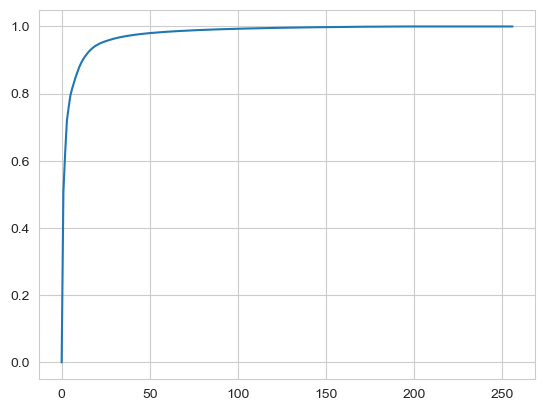

In [10]:
isLoadingFromFile = False

fname = os.path.join("fasta", "count_5_10000_10000", "som_2019_07_07_15_37", "weight.npz")

if isLoadingFromFile:
    with np.load(fname) as f:
        WEIGHT = f["w"]
    
    print_console_and_logfile(fname + "\n")
    print_console_and_logfile("rows = " + str(WEIGHT.shape[0]))
    print_console_and_logfile("cols = " + str(WEIGHT.shape[1]))
    print_console_and_logfile("dims = " + str(WEIGHT.shape[2]) + "\n")
    
    if WEIGHT.shape[2] != n_features:
        raise Exception(
            "Missmatch of WEIGHT tensor's shape: " + str(WEIGHT.shape[2]) + " != " + str(n_features) + ".")
else:
    print("*** DATA.shape =", DATA.shape)
    WEIGHT = create_weight_by_pca(DATA, PARAMS["AUTO_SCALE"])

## Create array of colors for SOM cells

In [11]:
import colorsys

hsv_to_rgb_list = [colorsys.hsv_to_rgb(h, 1.0, 1.0) for h in np.linspace(0, 240/360, len(NAMES))]
COLORS = np.array(hsv_to_rgb_list)
print("SHAPE: ", COLORS.shape)

black = (0.0, 0.0, 0.0)  # State in which different labels are assigned to the same cell
white = (1.0, 1.0, 1.0)  # Unassigned state

def palette(colObj):
    idx = colObj.index
    return COLORS[idx] if idx >= 0 else (white if idx == -1 else black)

def getColorArray(idx_array):
    np_array = np.array(idx_array)
    color_list = list(map(lambda i: palette(i), np_array.reshape(-1)))
    return np.array(color_list).reshape(np_array.shape[0], np_array.shape[1], 3)

SHAPE:  (5, 3)


##  Define class and functions used to compute the SOM

In [12]:
class CellColorIndex():
    def __init__(self):
        self.colIdx = -1
    
    def __repr__(self):
        return str(self.colIdx)
    
    @property
    def index(self):
        return self.colIdx
    
    def reset(self):
        self.colIdx = -1
    
    def set(self, val):
        if self.colIdx != -2:
            if self.colIdx == -1:
                self.colIdx = val
            else:
                if self.colIdx != val:
                    self.colIdx = -2

In [13]:
def create_image(cell_color, step):
    plt.axis("off")
    image = plt.imshow(cell_color, interpolation='none')
    fname = os.path.join(DIR_OUTPUT, '{0:04d}'.format(step))
    plt.savefig(fname, bbox_inches='tight')
    plt.close()
    
    return image

In [14]:
def find_matching_cell(weight, invec):
    min_idx = np.argmin(np.sum((weight - invec)**2, axis=2))
    rows, cols = weight.shape[:2]
    return np.unravel_index(min_idx, (rows, cols))

In [15]:
def get_neighbor_matrix(radius):
    size = 2 * radius + 1
    rs, cs = np.mgrid[0:size, 0:size]
    coordinates = np.hstack([rs.flatten()[:, np.newaxis], cs.flatten()[:, np.newaxis]])    
    
    center = np.array([radius, radius])
    dist = np.linalg.norm(coordinates - center, axis=1).reshape(size, size)
    
    nb_mat = 1.0 - dist / radius
    nb_mat[nb_mat < 0] = 0.0
    
    return nb_mat

In [16]:
def calc_neighbor_effect(r, c, radius, invec, nb_mat, neighbor_sum, neighbor_cnt):    
    r_row_min = max(radius - r, 0)
    r_row_max = min(radius - r + rows, 2 * radius + 1)
    r_col_min = max(radius - c, 0)
    r_col_max = min(radius - c + cols, 2 * radius + 1)
    
    dc = nb_mat[r_row_min:r_row_max, r_col_min:r_col_max]

    w_row_min = max(r - radius, 0)
    w_row_max = min(r + radius + 1, rows)
    w_col_min = max(c - radius, 0)
    w_col_max = min(c + radius + 1, cols)
    
    neighbor_sum[w_row_min:w_row_max, w_col_min:w_col_max] += invec * dc[:, :, np.newaxis]
    neighbor_cnt[w_row_min:w_row_max, w_col_min:w_col_max] += dc

In [17]:
def get_next_params(step):    
    radius = max(round(PARAMS["RADIUS_INITIAL"] - step * PARAMS["RADIUS_DELTA"]), 0)
    isExistNextRange = True
    
    if radius < PARAMS["RADIUS_FINAL"]:
        radius = PARAMS["RADIUS_FINAL"]
        isExistNextRange = False
    
    alpha = max(PARAMS["LEARNING_INITIAL"] - step * PARAMS["LEARNING_DELTA"], 0)
    isExistNextAlpha = True
    
    if alpha < PARAMS["LEARNING_FINAL"]:
        alpha = PARAMS["LEARNING_FINAL"]
        isExistNextAlpha = False
    
    isExist = isExistNextRange or isExistNextAlpha
    
    return isExist, radius, alpha

In [18]:
print_console_and_logfile("Elapsed Time  : " + str(datetime.datetime.now() - start_time) + "\n")

Elapsed Time  : 0:00:10.906546



## Output Legend

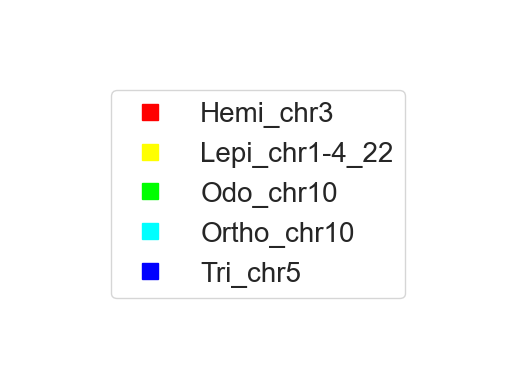

In [19]:
plt.axis("off")

f = lambda c: plt.plot([], [], marker="s", color=c, linestyle="none")[0]
handles = [f(c) for c in COLORS]
legend = plt.legend(handles, NAMES, loc="center", frameon=True, fontsize=20, markerscale=2)
legend.set_alpha(1.0)

fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array([-5, -5, 5, 5])))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

fname = os.path.join(DIR_OUTPUT, "legend.png")
fig.savefig(fname, dpi="figure", bbox_inches=bbox)

plt.show()

## Start SOM calculation

In [20]:
start = datetime.datetime.now()

rows, cols = WEIGHT.shape[:2]
neighbor_sum = np.zeros((rows, cols, n_features))
neighbor_cnt = np.zeros((rows, cols))

CELL_LABEL = [[CellColorIndex() for j in range(cols)] for i in range(rows)]

radius = PARAMS["RADIUS_INITIAL"] = round(PARAMS["RADIUS_RATE"] * cols)
alpha  = PARAMS["LEARNING_INITIAL"]

fig = plt.figure()

step   = 0
while True:
    begin = datetime.datetime.now()
    
    neighbor_sum.fill(0.0)
    neighbor_cnt.fill(0.0)
    
    for r in range(rows):
        for c in range(cols):
            CELL_LABEL[r][c].reset()
        
    res = Parallel(n_jobs=-1)(
          [delayed(find_matching_cell)(WEIGHT, DATA[i])
          for i in range(n_samples)])
    
    nb_mat = get_neighbor_matrix(radius)
    
    rs, cs = zip(*res)
    for i, (r, c) in enumerate(zip(rs, cs)):
        calc_neighbor_effect(r, c, radius, DATA[i], nb_mat, neighbor_sum, neighbor_cnt)
        CELL_LABEL[int(r)][int(c)].set(TARGET[i])
    
    np.seterr(divide='ignore', invalid='ignore')
    
    ncnt = neighbor_cnt[:, :, np.newaxis]
    average = np.where(ncnt == 0, np.zeros_like(neighbor_sum), neighbor_sum / ncnt)
    
    dw = alpha * (average - WEIGHT)
    
    WEIGHT += dw
    
    cell_color = getColorArray(CELL_LABEL)
    image = create_image(cell_color, step)
    
    dist = np.linalg.norm(dw)
    ds1 = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    ds2 = "{:.2f}".format((datetime.datetime.now() - begin).total_seconds())
    print_console_and_logfile(
        "Step = {:5d}, Radius = {:2d}, alpha = {:.4f}, dist = {:.4f} : Time = {} - {}".format(
        step, radius, alpha, dist, ds1[:-4], ds2))

    step += 1
    isExist, radius, alpha = get_next_params(step)
    if not isExist:
        break

print_console_and_logfile("\nSOM : " + str(datetime.datetime.now() - start))

plt.show()

Step =     0, Radius = 14, alpha = 0.2000, dist = 0.1823 : Time = 2023-05-23 22:42:44.35 - 11.45
Step =     1, Radius = 14, alpha = 0.1980, dist = 0.1226 : Time = 2023-05-23 22:42:53.64 - 9.29
Step =     2, Radius = 14, alpha = 0.1960, dist = 0.0909 : Time = 2023-05-23 22:43:02.87 - 9.23
Step =     3, Radius = 14, alpha = 0.1940, dist = 0.0707 : Time = 2023-05-23 22:43:11.98 - 9.11
Step =     4, Radius = 14, alpha = 0.1920, dist = 0.0564 : Time = 2023-05-23 22:43:21.37 - 9.40
Step =     5, Radius = 14, alpha = 0.1900, dist = 0.0496 : Time = 2023-05-23 22:43:30.75 - 9.38
Step =     6, Radius = 13, alpha = 0.1880, dist = 0.0476 : Time = 2023-05-23 22:43:39.33 - 8.57
Step =     7, Radius = 13, alpha = 0.1860, dist = 0.0436 : Time = 2023-05-23 22:43:47.90 - 8.57
Step =     8, Radius = 13, alpha = 0.1840, dist = 0.0423 : Time = 2023-05-23 22:43:56.39 - 8.49
Step =     9, Radius = 13, alpha = 0.1820, dist = 0.0408 : Time = 2023-05-23 22:44:04.58 - 8.19
Step =    10, Radius = 13, alpha = 0.18

Step =    86, Radius =  5, alpha = 0.1000, dist = 0.0125 : Time = 2023-05-23 22:52:48.09 - 6.33
Step =    87, Radius =  5, alpha = 0.1000, dist = 0.0110 : Time = 2023-05-23 22:52:54.45 - 6.36
Step =    88, Radius =  5, alpha = 0.1000, dist = 0.0099 : Time = 2023-05-23 22:53:00.85 - 6.40
Step =    89, Radius =  5, alpha = 0.1000, dist = 0.0088 : Time = 2023-05-23 22:53:07.31 - 6.46
Step =    90, Radius =  5, alpha = 0.1000, dist = 0.0079 : Time = 2023-05-23 22:53:13.67 - 6.36
Step =    91, Radius =  5, alpha = 0.1000, dist = 0.0069 : Time = 2023-05-23 22:53:20.08 - 6.41
Step =    92, Radius =  5, alpha = 0.1000, dist = 0.0063 : Time = 2023-05-23 22:53:26.44 - 6.37
Step =    93, Radius =  5, alpha = 0.1000, dist = 0.0056 : Time = 2023-05-23 22:53:32.84 - 6.40
Step =    94, Radius =  5, alpha = 0.1000, dist = 0.0050 : Time = 2023-05-23 22:53:39.20 - 6.36
Step =    95, Radius =  4, alpha = 0.1000, dist = 0.0165 : Time = 2023-05-23 22:53:45.49 - 6.29
Step =    96, Radius =  4, alpha = 0.100

## Saving learning results

In [21]:
fname = os.path.join(DIR_OUTPUT, "weight.npz")
np.savez_compressed(fname, w=WEIGHT)

## Outputs U-Matrix diagrams

In [22]:
dr = 1

print("WEIGHT.shape = ", WEIGHT.shape)

sizeY = WEIGHT.shape[0]
sizeX = WEIGHT.shape[1]

def calcColorByValue(distArray):
    maxv = np.max(distArray)
    minv = np.min(distArray)
    width = maxv - minv
    
    colorArray = np.sqrt((distArray - minv) / width)
    
    return colorArray

distArray = np.zeros((sizeY, sizeX))

for ix in range(sizeX):
    for iy in range(sizeY):
        weight = WEIGHT[iy, ix, :]
        distArray[iy][ix] = 0
        
        for dx in range(-dr, dr+1):
            nx = ix + dx
            if (nx < 0 or nx >= sizeX):
                continue
            
            y2 = dr * dr - dx * dx
            dyMax = int(np.round(np.sqrt(y2)))
            
            for dy in range(-dyMax, dyMax + 1):
                ny = iy + dy
                if (ny < 0 or ny >= sizeY):
                    continue
                
                if (nx == ix and ny == iy):
                    continue
                
                nWeight = WEIGHT[ny, nx, :]
                
                dist = np.linalg.norm(weight - nWeight)
                distArray[iy][ix] += dist

colorArray = calcColorByValue(distArray)

plt.axis("off")
plt.imshow(colorArray, cmap="Greys", interpolation='none')
plt.clim(0.0, 1.0)
fname = os.path.join(DIR_OUTPUT, "U-Matrix.png")
plt.savefig(fname, bbox_inches='tight')
plt.close()

WEIGHT.shape =  (27, 57, 256)


## Output a diagram of the component analysis

In [23]:
import sys

def create_comp_image(index, fname):
    sizeY = WEIGHT.shape[0]
    sizeX = WEIGHT.shape[1]
    
    maxv = -sys.float_info.max
    minv =  sys.float_info.max
    
    for ix in range(sizeX):
        for iy in range(sizeY):
            weight = WEIGHT[iy, ix, index]
            if weight < minv:
                minv = weight
            if weight > maxv:
                maxv = weight
    
    comp_color_array = np.zeros((sizeY, sizeX))
    width = maxv - minv
    
    for ix in range(sizeX):
        for iy in range(sizeY):
            weight = WEIGHT[iy, ix, index]
            comp_color_array[iy][ix] = (weight - minv) / width
    
    plt.axis("off")
    plt.imshow(comp_color_array, cmap="bwr", interpolation='none')
    plt.clim(0.0, 1.0)
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

def save_comp_image_from_index(index):
    idx = int(index)
    fname = os.path.join(comp_dir, NUC_LABELS[idx])
    create_comp_image(idx, fname)

def save_comp_image_from_string(string):
    try:
        index = NUC_LABELS.index(string)
    except:
        raise Exception(string + " is not included in NUC_LABELS.")
    
    save_comp_image_from_index(index)

In [24]:
comp_dir = os.path.join(DIR_OUTPUT, 'comp')
if not os.path.isdir(comp_dir):
    os.mkdir(comp_dir)

In [25]:
start = datetime.datetime.now()

dims = WEIGHT.shape[2]

try:
    res = Parallel(n_jobs=-1)(
        [delayed(save_comp_image_from_index)(index)
         for index in range(dims)])
except:
    pass
'''
for index in range(dims):
    idx = int(index)
    save_comp_image_from_index(idx)
'''

print_console_and_logfile("\nSaving images of all components : " + str(datetime.datetime.now() - start) + "\n")


Saving images of all components : 0:00:03.969592



In [26]:
end_time = datetime.datetime.now()
print_console_and_logfile("\nStart   Time  : " + str(start_time))
print_console_and_logfile(  "End     Time  : " + str(end_time))
print_console_and_logfile(  "Elapsed Time  : " + str(end_time - start_time) + "\n")


Start   Time  : 2023-05-23 22:42:21.780295
End     Time  : 2023-05-23 22:56:58.179380
Elapsed Time  : 0:14:36.399085



In [27]:
LOGF.close()